# Create all_keywords files from UMAP

In [21]:
## Inport packages
from pathlib import Path
import os
import codecs
import re
import logging
import locale
import dataclasses
import copy
from itertools import groupby
from itertools import compress
from datetime import datetime
from typing import List
import jinja2
import pandas as pd
import numpy as np
from DABI_databases import *
# import umap as umap
import umap.umap_ as umap



## Functions
# Remove known non-keywords from keyword list
def filter_words(variable):
    remove_words = ["Ancient","Cave","Desert","Near","Oral","East","South","Text","article","aspect","basis","comment","course","description",
                    "effect","extenso","mean","need","paper","text","volume","a","and","of","the","-pron-","in",
                    "The", "an", "An", "by", "le", "les", "on", "for", "this",
                    "their", "most", "\n  \n", "\n   \n", "\n     \n", "these", "that", "many", "some", "these", "also",
                    "such", "which", "palestine._id%c3%a9ologies_religieuses_entre_ugarit_et_le_monde_ph%c3%a9nicien_ugarit"]
    if (variable in remove_words):
        return False
    else:
        return True



In [22]:
## From Jonah's file

MYPATH = "./raw_data/"

#reference copy of previous working implementation of spaCy

#this is a new NLP attempt, implementing spaCy to output one large csv with topics inside it
#this version outputs parsed_dabi_filesNLP2.csv a csv with filename, author, year, and topic list

import fnmatch
import os
from pathlib import Path
import pandas as pd
import csv
import sys
from gensim.summarization import keywords
import spacy

#make a function to check for certain strings
def check_if_string_in_file(file_name, string_to_search):
    # Check if any line in the file contains given string
    # Open the file in read only mode
    with open(file_name, 'r') as read_obj:
        # Read all lines in the file one by one
        for line in read_obj:
            # For each line, check if line contains the string
            if string_to_search in line:
                return True
    return False

def search_string_in_file(file_name, string_to_search):
    #Search for the given string in file and return the lines containing that string
    #only works for unique strings in file
    line_number = 0
   
    # Open the file in read only mode
    with open(file_name, 'r') as read_obj:
        # Read all lines in the file one by one
        for line in read_obj:
            # For each line, check if line contains the string
            line_number += 1
            if string_to_search in line:
                # If yes, then add the line to the list
               return line.rstrip()
    

#clear main lists
filename = []
author = []
year = []
topics = []
nlp = spacy.load("en_core_web_sm")

#main program loop
#loop through all the .d files in the directory
for currentfile in os.listdir(MYPATH):
    if fnmatch.fnmatch(currentfile, '*.d'):
        data_folder = Path(MYPATH)
        file_to_open = data_folder / currentfile

        f = open(file_to_open)
        # Check if string '@@@R' is found in file, which means we are referring to material for the Mes/Rel site
        if check_if_string_in_file(file_to_open, '@@@R'):

            #take the filename for each @@@R file and populate the lists (cutting off .d extension)
            filename.append(currentfile[:-2])
            
            #choose AU (author) line and append to list
            au = search_string_in_file(file_to_open, 'AU ')
            if au is None: #make sure we don't get null values in list 
                au = 'AU None'
            author.append(au[3:])
            
            #choose Y (year) line and append to list    
            y = search_string_in_file(file_to_open, 'Y ')
            if y is None: #make sure we don't get null values in list 
                y = 'Y None'
            year.append(y[2:6]) #at most allow four digits for year
               
            shortfile = [] # routine to strip the header from the file, leaving only the title, topic line and summary
            for line in f:
                if "T " in line:
                    break
            shortfile.append(line)        
            for line in f:
                if "SD" in line:
                    break
            for line in f:
                shortfile.append(line)
                if "@NOTES" in line:
                    break
            a_string = "".join(shortfile[:-1]) #join all lines except the last one (the @NOTES line)
            
            #NLP routine to parse keywords in the shortened file
            doc = nlp(a_string)
                
            t = []
            topic_list = []
    
            for t in doc:
                
                if len(t)<4: #get rid of short words
                    continue
                if t.pos_ == 'NUM' or t.pos_ == 'AUX' or t.pos_ == 'ADP' or t.pos_ == 'SYM' or t.pos_ == 'AUX': #get rid of numbers, auxiliary verbs, prepositions, symbols
                    continue
                if t.text.find("http") != -1: #get rid of hyperlinks
                    continue
                if any(c.isdigit() for c in t.text): #get rid of words containing numbers
                    continue        
                if t.text.find("@") != -1: #get rid of site references
                    continue
                if t.text.find("_") != -1: #get rid of dashed words
                    continue    
                if t.text.find("%") != -1: #get rid of percent signs
                    continue 
                if t.text.find(".") != -1: #get rid of period signs
                    continue     
                if t.text.find("/") != -1: #get rid of slash signs
                    continue     
                if t.text.find("&") != -1: #get rid of words with & signs
                    continue 
                if t.text.find("'") != -1: #get rid of words with ' signs
                    continue     
                if t.text.find("{") != -1: #get rid of words with { signs
                    continue    
                if t.text.find("*") != -1: #get rid of words with * signs
                    continue    
                if t.text.find(".pdf") != -1: #get rid of file references
                    continue
                if t.text.find(".html") != -1: #get rid of file references
                    continue
                if t.text.find("R/") != -1: #get rid of reference codes
                    continue     
                if t.text.find("\n\n") != -1: #get rid of carriage returns
                    continue
                if t.pos_ == "PROPN":  #put proper names in the list with capital letter
                    topic_list.append(t.lemma_)
                    continue  
                if t.pos_ != "NOUN": #keep only nouns
                    continue 
                topicToAdd = t.lemma_
                topicToAdd = topicToAdd.lower()  #make everything except proper names lowercase
                topic_list.append(topicToAdd)    #append the lemma of each word to the list
                
            topics.append(topic_list)
 
a = {'filename': filename, 'author': author, 'year': year, 'keywords': [list(filter(filter_words,topic)) for topic in topics]}

df = pd.DataFrame(a, columns=['filename','author','year', 'keywords'])
df.head()


,filename,author,year,keywords
0,Nissinen2019Divination,"Nissinen, Martti",2019,"[divination, essay, Eastern, Prophecy, divinat..."
1,Cohen2018MoralityInAntiquity,"Cohen, Yoram",2018,"[morality, Antiquity, tradition, proverb, comp..."
2,Scheil1913Memoires,"Scheil, Jean Vincent",1913,"[Mémoires, mission, archéologique, Susiane, dr..."
3,Rubio1999Substratum,"Rubio, Gonzalo",1999,"[Substratum, substratum, topic, problem, Sumer..."
4,Annus2010Divination,"Annus, Amar (ed.)",2010,"[divination, Interpretation, Signs, World, div..."


In [24]:
## Create list of keywords -- will become the nodes

all_keywords = np.unique([item for sublist in df.keywords for item in sublist])
print(f'Identified {all_keywords.shape[0]} nodes (keywords)')


Identified 4193 nodes (keywords)


In [68]:
## Reshape the data so that we have one row per keyword

file_list = []
author_list = []
keyword_list = []

for r in np.arange(len(all_keywords)):

    filenames_for_keyword = []
    matching_rows = [ind for (ind,value) in enumerate(df.keywords) if all_keywords[r] in value]

    file_list.append(list(df.filename[matching_rows]))
    author_list.append(list(df.author[matching_rows]))

    
df_keywords = pd.DataFrame({'keyword': all_keywords, 'filenames': file_list, 'authors': author_list})


#shorten dataframe to include only those rows that contain more than minimumKey filenames per keyword
minimumKey = 1

df_keywords = df_keywords.loc[df_keywords["filenames"].apply(lambda x: len(x) > minimumKey)]
df_keywords.index = range(0, len(df_keywords["keyword"]), 1)      #re-index the dataframe
df_keywords.head()

,keyword,filenames,authors
0,Abraham,"[Box1918Apocalypse, Winitzer2017Divination, de...","[Box, George Herbert and Landsman, Joseph Imma..."
1,Adad,"[Schwemer2001Wettergottgestalten, Gurzadyan200...","[Schwemer, Daniel, Gurzadyan, V.G.]"
2,Addu,"[Schwemer2001Wettergottgestalten, Charpin2015D...","[Schwemer, Daniel, Charpin, Dominique]"
3,Akkadian,"[Cohen2018MoralityInAntiquity, Stamm1939Nameng...","[Cohen, Yoram, Stamm, Johann Jakob, Reiner, ..."
4,Albertz,"[Cohen2016Theodicy, Cohen2015ProblemOfTheodicy]","[Cohen, Yoram, Cohen, Yoram]"


In [69]:
# Make a giant nKeywords x nFiles incidence matrix (data frame)
all_files = list(df.filename)
important_keywords = df_keywords["keyword"]

# One row per keyword
all_data_df = pd.DataFrame(0, index=np.arange(len(important_keywords)), columns=all_files)
all_data_df.head()

,Nissinen2019Divination,Cohen2018MoralityInAntiquity,Scheil1913Memoires,Rubio1999Substratum,Annus2010Divination,Charpin2002Prophetes,Parpola1997SAA9,Urkesh,Buccellati2012Coerenza,Stamm1939Namengebung,...,Kleinerman2011Epistolary,DeZorzi2011Omina,Ebla,Ermidoro2017Atrahasis,Xella2001Quando,Bonechi1989Ebla,Bisi2011Babel,Holloway2001Assur,Moscati1997Imperi,Buccellati1972Beatitudini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Populate with keyword incidence. Need to loop through keywords
for (n, keyword) in enumerate(important_keywords):
    
    # Find files of the keyword
    keyword_files = df_keywords.filenames[n]
    
    # Find index of files in all_files
    file_indices = [list(all_files).index(file) for file in keyword_files]

    
    # Populate these rows of all_data_df with 1 indicating that the file mentions this keyword
    # If one wanted to add strength based on location of the keyword (title, notes, etc) do this here.
    for file_index in file_indices:
        all_data_df[all_files[file_index]][n] = 1
    
    
all_data_df.head()
    


,Nissinen2019Divination,Cohen2018MoralityInAntiquity,Scheil1913Memoires,Rubio1999Substratum,Annus2010Divination,Charpin2002Prophetes,Parpola1997SAA9,Urkesh,Buccellati2012Coerenza,Stamm1939Namengebung,...,Kleinerman2011Epistolary,DeZorzi2011Omina,Ebla,Ermidoro2017Atrahasis,Xella2001Quando,Bonechi1989Ebla,Bisi2011Babel,Holloway2001Assur,Moscati1997Imperi,Buccellati1972Beatitudini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
## Run UMAP

reducer = umap.UMAP()
embedding = reducer.fit_transform(all_data_df)
embedding.shape

(1580, 2)

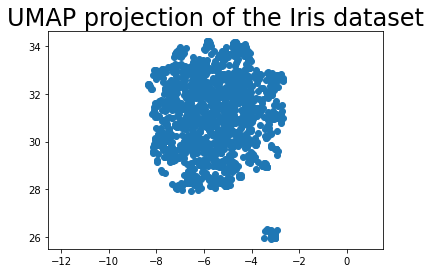

In [72]:
import matplotlib.pyplot as plt
import umap.plot
import datashader
import bokeh
import holoviews

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Iris dataset', fontsize=24);

In [73]:
# Add x, y values to the main data frame
df_keywords["x"] = embedding[:, 0]
df_keywords["y"] = embedding[:, 1]
df_keywords.head()

,keyword,filenames,authors,x,y
0,Abraham,"[Box1918Apocalypse, Winitzer2017Divination, de...","[Box, George Herbert and Landsman, Joseph Imma...",-6.782311,33.172359
1,Adad,"[Schwemer2001Wettergottgestalten, Gurzadyan200...","[Schwemer, Daniel, Gurzadyan, V.G.]",-7.620671,32.236107
2,Addu,"[Schwemer2001Wettergottgestalten, Charpin2015D...","[Schwemer, Daniel, Charpin, Dominique]",-7.384317,32.455902
3,Akkadian,"[Cohen2018MoralityInAntiquity, Stamm1939Nameng...","[Cohen, Yoram, Stamm, Johann Jakob, Reiner, ...",-3.431971,28.974621
4,Albertz,"[Cohen2016Theodicy, Cohen2015ProblemOfTheodicy]","[Cohen, Yoram, Cohen, Yoram]",-4.596524,34.109085


In [74]:
df_keywords.to_csv("./data/all_keywords_umap.csv")

<AxesSubplot:>

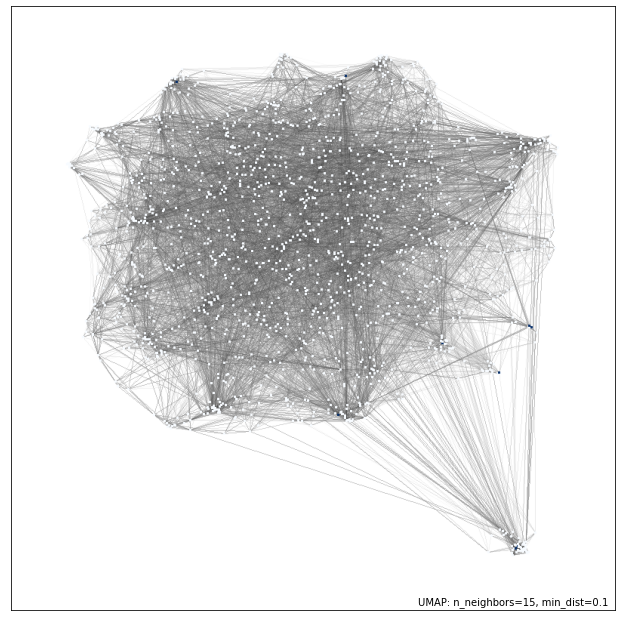

In [75]:
umap.plot.connectivity(reducer, show_points=True)
#umap.plot.connectivity(reducer, edge_bundling='hammer')